In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.models import save_model
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
import re
import keras.backend as K
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv("/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/4.1 Train Test Baru/50 Manual/train.csv")
df_test = pd.read_csv("/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/4.1 Train Test Baru/50 Manual/test.csv")

In [5]:
df.head()

,raw,text,labels
0,tempat nya selalu ramai pengunjung harga nya s...,tempat nya selalu ramai unjung harga nya sanga...,1
1,"warna tidak sesuai tetapi okelah , lain kali m...",warna tidak sesuai tetapi oke lain kali mohon ...,0
2,"kalau anda pergi ke bandung , jangan lupa maka...",kalau anda pergi ke bandung jangan lupa makan ...,1
3,ini pak bela bu susi dan tekankan bahwa upaya-...,ini pak bela bu sus dan tekan bahwa upaya upay...,0
4,minimal indomie goreng exp . date masih kurang...,minimal indomie goreng exp date masih kurang b...,0


In [6]:
X = np.array(df['text'].tolist())
y = np.array(df['labels'].tolist())

In [7]:
x_train,x_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2, 
                                                 random_state=10)

In [8]:
className = {
    0 : 0,
    1 : 1
}
def oneHotEncode(listArray):
  s = (len(listArray),len(np.unique(listArray)))
  tempData = np.zeros(s)
  for i in range(len(listArray)):
    if listArray[i] == 1:
      tempData[i][1] = 1
    elif listArray[i] == 0:
      tempData[i][0] = 1
  return tempData

y_train = oneHotEncode(y_train)
y_test = oneHotEncode(y_test)

In [9]:
y_train

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [10]:
# Setup text vectorization variables
max_vocab_length = 350 # max number of words to have in our vocabulary
max_length = 33
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [11]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X)

In [12]:
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input

embedding

In [13]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(x_train)
X = tokenizer.texts_to_sequences(x_train)
X = pad_sequences(X)

In [14]:
# MODEL CNN-LSTM
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x) # return vector for whole sequence
out = tf.keras.layers.Dense(64, activation='relu')(x)
out = tf.keras.layers.Dropout(0.5)(out)
outputs = layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="model_LSTM")

In [15]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
        tf.keras.metrics.TruePositives(name='TruePositive'),
        tf.keras.metrics.FalsePositives(name='FalsePositive'),
        tf.keras.metrics.TrueNegatives(name='TrueNegative'),
        tf.keras.metrics.FalseNegatives(name='FalseNegative'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        get_f1
      ]
# Compile model
model.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics=METRICS)

In [16]:
model.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 33)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 33, 128)           44800     
                                                                 
 conv1d (Conv1D)             (None, 33, 32)            8224      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               8

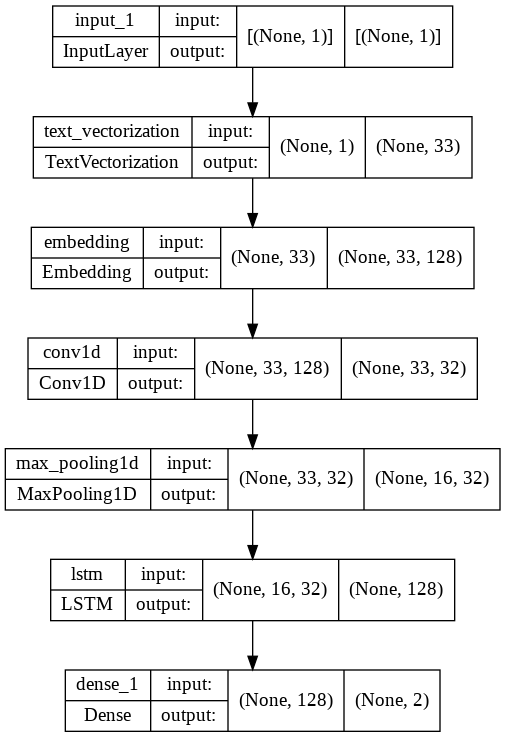

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
epoch = 5
# Fit model

model_history = model.fit(x_train,
                          y_train,
                          epochs=epoch,
                          batch_size=64,
                          validation_data=(x_test, y_test),
                          verbose=1,
                          )

Epoch 1/5
151/151 [==============================] - 29s 93ms/step - loss: 0.5640 - TruePositive: 6721.0000 - FalsePositive: 2919.0000 - TrueNegative: 6721.0000 - FalseNegative: 2919.0000 - accuracy: 0.6972 - precision: 0.6972 - recall: 0.6972 - auc: 0.7755 - get_f1: 0.6975 - val_loss: 0.4946 - val_TruePositive: 1849.0000 - val_FalsePositive: 561.0000 - val_TrueNegative: 1849.0000 - val_FalseNegative: 561.0000 - val_accuracy: 0.7672 - val_precision: 0.7672 - val_recall: 0.7672 - val_auc: 0.8417 - val_get_f1: 0.7685
Epoch 2/5
151/151 [==============================] - 13s 84ms/step - loss: 0.4726 - TruePositive: 7473.0000 - FalsePositive: 2167.0000 - TrueNegative: 7473.0000 - FalseNegative: 2167.0000 - accuracy: 0.7752 - precision: 0.7752 - recall: 0.7752 - auc: 0.8557 - get_f1: 0.7752 - val_loss: 0.4839 - val_TruePositive: 1847.0000 - val_FalsePositive: 563.0000 - val_TrueNegative: 1847.0000 - val_FalseNegative: 563.0000 - val_accuracy: 0.7664 - val_precision: 0.7664 - val_recall: 0.76

In [19]:
model_history.history["epochs"] = list(range(1,epoch+1))

In [20]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y= model_history.history["accuracy"],x= model_history.history["epochs"],mode="lines+markers",name="Training accuracy"))
fig.add_trace(go.Scatter(y= model_history.history["loss"],x= model_history.history["epochs"],mode="lines+markers",name="Training loss"))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(y= model_history.history["val_accuracy"],x= model_history.history["epochs"],mode="lines+markers",name="Val accuracy"))
fig.add_trace(go.Scatter(y= model_history.history["val_loss"],x= model_history.history["epochs"],mode="lines+markers",name="Val loss"))
fig.show()

In [21]:
X = np.array(df_test['text'].to_list())
y = oneHotEncode(np.array(df_test['labels'].tolist()))

In [22]:
model.evaluate(X, y, batch_size=64)

5/5 [==============================] - 0s 46ms/step - loss: 0.6489 - TruePositive: 178.0000 - FalsePositive: 90.0000 - TrueNegative: 178.0000 - FalseNegative: 90.0000 - accuracy: 0.6642 - precision: 0.6642 - recall: 0.6642 - auc: 0.7083 - get_f1: 0.6104


[0.6488876342773438,
 178.0,
 90.0,
 178.0,
 90.0,
 0.6641790866851807,
 0.6641790866851807,
 0.6641790866851807,
 0.7083356380462646,
 0.61041659116745]

In [27]:
data = {
    "astra" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/astrazeneca.csv",
    "pfizer" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/pfizer.csv",
    "moderna" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/moderna.csv",
    "sinopharm" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/sinopharm.csv",
    "sinovac" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/sinovac.csv",
    "gratis" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/gratis.csv",
    "bayar" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/bayar.csv",
    "efektif" : "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/efektif.csv",
}

In [24]:
def predictText(text):
  # data = DataCleaning.CleanSentence(data)
  return className[np.argmax(model.predict([text]))]

In [35]:
csv_out_data_path = "/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/5. Predict Data/predicted/CNN-LSTM"
for d in data:
  print(data[d])
  df_predict = pd.read_csv(data[d])
  listPredict = model.predict(df_predict['clean'])
  listPredictJadi = []
  for predict in listPredict:
    listPredictJadi.append(className[np.argmax(predict)])
  df_predict['prediction'] = listPredictJadi
  df_predict.to_csv(f"{csv_out_data_path}/{d}.csv")

/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/astrazeneca.csv
/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/pfizer.csv
/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/moderna.csv
/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/sinopharm.csv
/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/sinovac.csv
/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/gratis.csv
/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/bayar.csv
/content/drive/Shareddrives/Riset Sentimen Vaksin COVID: Yaudahlah/Riset/Data/2. Clean/Twitter/v3/efektif.csv


In [26]:
predictText("anjing kalian semua babi")

0